## Generate some conditioned trajectory from DOE


Morgane Menz ONERA - UPS

Use of the GP ONERA library:

- Gaussian process from scikit learn <0.18

- We add some functions to the class GaussianProcess defined in gaussian_process.py
(4 functions added (conditioned_covariance_function, random_trajectories, KL_expansion, eval_KL_vect))


In [1]:
from gaussian_process import GaussianProcess


In [2]:

import numpy as np
import scipy as sci
from scipy.stats import norm
import openturns as ot


import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
from matplotlib import rc

from matplotlib import cm

params = {'backend': 'ps',
      'axes.labelsize': 55,
      'legend.fontsize': 44,
      'xtick.labelsize': 40,
      'ytick.labelsize': 40,
      'text.usetex': True,
      'text.latex.unicode':True}

rcParams.update(params)

Definition of the function to approximate 

In [3]:
def f(x): 
    x=4*x-2
    y=x*np.sin(np.pi*(x+3.5))
    return y 

    

Create the DOE and the associated GP

In [4]:
    
stochastic_dim = 1    
theta0 = np.array([0.1]*stochastic_dim)
thetaL = np.array([1e-6]*stochastic_dim)
thetaU = np.array([100.0]*stochastic_dim)
gp_g = GaussianProcess(theta0 = theta0,thetaL=thetaL,thetaU=thetaU)     
gp_g0 = GaussianProcess(theta0 = theta0,thetaL=thetaL,thetaU=thetaU)     

n=5
DoE=np.linspace(0,1,n).reshape(n,1)
DoE=np.array([0.25,0.45,0.6,0.75,0.8]).reshape(n,1)

Y=f(DoE).reshape(n,1)

Fit the GP

In [5]:
#fitting the kriging surrogate
gp_g.fit(DoE,Y)

x_mc=np.arange(0,1,0.005)
x_mc=x_mc.reshape(x_mc.shape[0],1)
y_true=f(x_mc)
mu_gp,var_gp=gp_g.predict(x_mc,eval_MSE=True)
gp_p=mu_gp+3*np.sqrt(var_gp.reshape(x_mc.shape[0],1))
gp_m=mu_gp-3*np.sqrt(var_gp.reshape(x_mc.shape[0],1))

#  Trajectory evaluation
Two methods are proposed here:

1 - A classic method based on a cholesky decomposition of the conditioned covariance matrix 

Limits :
- For large sets of data, the covariance matrix is often ill-conditioned. Thus its Cholesky decomposition can not                                    be assessed numericaly 
- subjet to memory problems

2 - A procedure that consits in :
- simulating of a non conditioned gaussian process using its Karhunen Loeve(KL) reprensentation 
- then conditioning the obtained realisations

Limit : Memory problems for large sets of data when the stochastic dimension is high 

# 1 - Classical simulation of GP trajectories


The simulation of a trajectory of the GP $\mathcal{G}_n$ on a set of points $\tilde{x}$ corresponds to a realization of  $\mathcal{G}_n(\tilde{x}) \sim GP(\mu_n(\tilde{x}), C_n(\tilde{x}))$, with $C_n(\tilde{x})$ the covariance matrix conditioned by $\left( x_{doe}f(x_{doe}) \right)$ computed at points $\tilde{x}$. The trajectory is then obtained by : 
\begin{equation}
  \mathcal{G}_n(\tilde{x})=  \mu_n(\tilde{x}) + L_n(\tilde{x}) \xi
\end{equation}
with $\xi_i \sim \mathcal{N}(0,1)$ and $L_n(\tilde{x})$ a matrix obtained by the Cholesky decomposition of $C_n(\tilde{x})$ : 
\begin{equation}
  C_n(\tilde{x})= L_n(\tilde{x})L_n(\tilde{x})^T 
\end{equation}

In [6]:
################ evaluation trajectoires

# trajectoires classiques : matrice de covar cond + cholesky 
n_traj=10
traj= gp_g.random_trajectories(x_mc,n=n_traj,random_state=1)



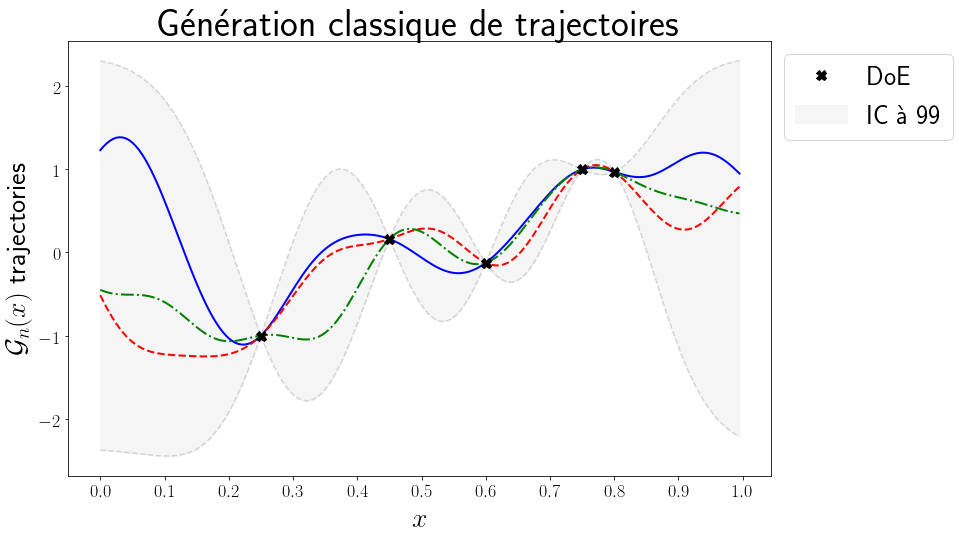

In [7]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.plot(DoE,Y,'kx')
#ax.plot(x_all,y_true,'r',label=r'Fonction')
ax.plot(x_mc,traj[0,:],'b',linewidth=2)
ax.plot(x_mc,traj[1,:],'r--',linewidth=2)
ax.plot(x_mc,traj[2,:],'g-.',linewidth=2)

ax.plot(x_mc,gp_p,'--',color='lightgray')
ax.plot(x_mc,gp_m,'--',color='lightgray')
ax.fill_between(x_mc[:,0], gp_p[:,0], gp_m[:,0],color='whitesmoke',label=u'IC à 99% du GP')
ax.plot(DoE,Y,'kX',markersize=10,label='DoE')

box = ax.get_position()
ax.set_position([box.x0-0.075, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor = (1, 1),fontsize=26)
ax.tick_params(labelsize=18)
ax.set_xticks([i for i in np.linspace(0,1,11)])
ax.set_xlabel(r'$x$',fontsize=28)
ax.set_ylabel(r'$\mathcal{G}_n(x)$ trajectories',fontsize=28)
ax.set_title(u'Génération classique de trajectoires',fontsize=38)
plt.show()

# 2 - Simulation of GP trajectories using the KL decomposition


 - Construction of the GP $\mathcal{G}_n$ conditioned with the observations $\left( x_{doe}f(x_{doe}) \right)$, i.e. optimization of the hyperparameters $\theta$, $\sigma_z$ et $\beta$.
 - Construction of a GP $\tilde{\mathcal{G}}(x)\sim GP \left(0,\sigma^2_Z r\left(x,x'\right)\right)$ using the optimal value of $\theta$ et $\sigma_z$ obtained previously.
  
- Simulation of a realization $\tilde{g}$ of $\tilde{\mathcal{G}}$ at points $(x,x_{doe})$
- Computation of $\tilde{\mu}(x)$ 
 \begin{equation}
\tilde{\mu}(x) = f(x)^T\tilde{\beta}+k(x)^TC^{-1} \left(\tilde{\mathcal{G}}(x_{doe})  - F\tilde{\beta} \right) 
\end{equation}
with $\tilde{\beta}=(F^TC^{-1}F)^{-1}F^TC^{-1}\tilde{g}(x_{doe})$

- Conditioning in order to obtain a trajectory of the conditioned GP $\mathcal{G}_n$ : $g(x) = \mu_n(x) - \tilde{\mu}(x) + \tilde{g}(x)$.

see:
- Villemonteix, J., E. Vazquez et E. Walter. 2009, «An informational approach to the global optimization of expensive-to-evaluate functions», Journal of Global Optimization, vol. 44, no 4, doi: 10.1007/s10898-008-9354-2, p. 509–534. URL https://hal-supelec.archives-ouvertes.fr/hal-00354262
or
- Le Gratiet, L., C. Cannamela et B. Iooss. 2014, «A Bayesian Approach for Global Sensitivity Analysis of (Multifidelity) Computer Codes», SIAM/ASA Journal on Uncertainty Quantification, vol. 2, no 1, doi: 10.1137/130926869, p. 336–363. URL https://epubs.siam.org/doi/abs/10.1137/130926869

Moreover, the simulation of the trajectories of $\tilde{\mathcal{G}}$ is done using its (truncated) KL representation :
\begin{equation}
\tilde{\mathcal{G}}(x) \approx  \sum_{i=1}^{M} \sqrt{\lambda_i} \phi_i(x) \xi_i(\omega)
\end{equation}
with  $\lambda_i \geq 0$, $\phi_i: \mathcal{X} \rightarrow \mathbb{R}$ the eigen values and associated eigen functions.

For the numerical estimation of $\lambda_i$ and $\phi_i$ see: 

Betz, W., I. Papaioannou et D. Straub. 2014, «Numerical methods for the discretization of random fields by means of the Karhunen–Loève expansion», Computer Methods in Applied Mechanics and Engineering, vol. 271, doi: 10.1016/j.cma.2013.12. 010, p. 109–129, ISSN 0045-7825. URL http://www.sciencedirect.com/science/article/pii/S0045782513003502




Computation of the eigen values and associated eigen functions for the KL representation

In [8]:
Omega=np.array([[-4.,4.]*stochastic_dim]).reshape(stochastic_dim,2) #espace à discrétiser (normalisé ou non)
distrib=ot.Normal()
### choix entre deux versions : 
# version grille uniforme 
eig, vect_star, nodes, weights, M = gp_g.K_eig_noncond_grid(eps=1e-8,Omega=Omega,normalize_Omega=False,n_start=11)  
# version échantillonnage uniforme sur Omega
eig, vect_star, nodes, weights, M = gp_g.K_eig_noncond_randuniform(nb_vect=100, Omega=Omega,normalize_Omega=False,n_start=100,eps=1e-8)



Trajectories simulations and conditioning 

In [15]:
 # Evaluation of the eigen functions at the points x_mc
    
phi = gp_g.eval_phi_KL( weights, nodes, eig, vect_star, M, x_mc)   


#  trajectories simulation
x_norm=norm()
xi_traj=x_norm.rvs((M,n_traj),random_state=2)
traj_KL,phi=gp_g.eval_KL_expansion_trajectories_phi(weights=weights,nodes=nodes,eig=eig,vect=vect_star, M=M, x_new=x_mc,xi_traj=xi_traj,phi=phi)


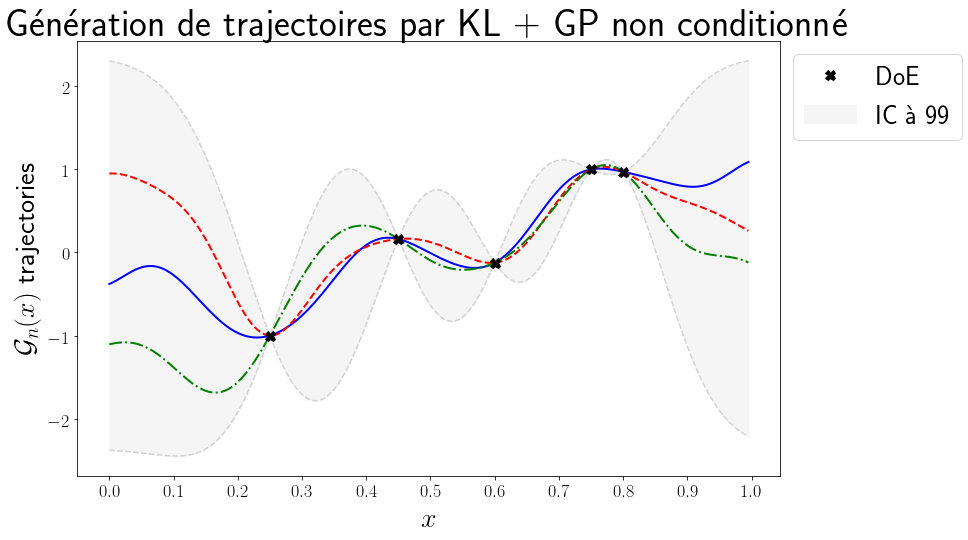

In [16]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.plot(DoE,Y,'kx')
#ax.plot(x_all,y_true,'r',label=r'Fonction')
ax.plot(x_mc,traj_KL[0,:],'b',linewidth=2)
ax.plot(x_mc,traj_KL[1,:],'r--',linewidth=2)
ax.plot(x_mc,traj_KL[2,:],'g-.',linewidth=2)

ax.plot(x_mc,gp_p,'--',color='lightgray')
ax.plot(x_mc,gp_m,'--',color='lightgray')
ax.fill_between(x_mc[:,0], gp_p[:,0], gp_m[:,0],color='whitesmoke',label=u'IC à 99% du GP')
ax.plot(DoE,Y,'kX',markersize=10,label='DoE')

box = ax.get_position()
ax.set_position([box.x0-0.075, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor = (1, 1),fontsize=26)
ax.tick_params(labelsize=18)
ax.set_xticks([i for i in np.linspace(0,1,11)])
ax.set_xlabel(r'$x$',fontsize=28)
ax.set_ylabel(r'$\mathcal{G}_n(x)$ trajectories',fontsize=28)
ax.set_title(u'Génération de trajectoires par KL + GP non conditionné',fontsize=38)
plt.show()
